In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

C:\Users\prave\anaconda3\envs\tensorflow3.9.5\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\prave\anaconda3\envs\tensorflow3.9.5\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\prave\anaconda3\envs\tensorflow3.9.5\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df=pd.read_csv("C://users/prave/Downloads/NewsCategorizer.csv")

In [3]:
# sample the dataset
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,category,headline,links,short_description,keywords
0,SPORTS,U.S. 'Shib Sibs' Win Over The World In 2018 Wi...,https://www.huffingtonpost.com/entry/shib-sibs...,Brother and sister Alex and Maia Shibutani too...,shib-sibs-win-over-the-world-in-2018-winter-ol...
1,FOOD & DRINK,Automatic Jam And Jelly Maker By Ball Seems Li...,https://www.huffingtonpost.com/entry/automatic...,It doesn't seem completely ground-breaking to ...,automatic-jam-and-jelly-maker-video
2,FOOD & DRINK,Amazing Crock Pot Recipes You Won't Believe Ca...,https://www.huffingtonpost.com/entry/crock-pot...,Think of your Crock Pot as a temperature-regul...,crock-pot-recipe-slow-cooker
3,SPORTS,Stephen Curry Started Off Super Bowl 50 With A...,https://www.huffingtonpost.com/entry/stephen-c...,#KeepPounding,stephen-curry-keep-pounding-drum
4,ENTERTAINMENT,Power in the Blood: Chatting With Buffy Sainte...,https://www.huffingtonpost.com/entry/power-in-...,Buffy's new new album Power In The Blood start...,power-in-the-blood-chatti


In [4]:
df['category'].value_counts()

SPORTS            5000
FOOD & DRINK      5000
ENTERTAINMENT     5000
TRAVEL            5000
STYLE & BEAUTY    5000
BUSINESS          5000
WELLNESS          5000
PARENTING         5000
WORLD NEWS        5000
POLITICS          5000
Name: category, dtype: int64

In [5]:
df['category'] = df['category'].astype('category')
df['category'] = df['category'].cat.codes

In [6]:
df.isnull().sum()

category                0
headline                0
links                   0
short_description       0
keywords             2668
dtype: int64

In [7]:
# drop the "keyword" and "link" features
df.drop(columns=['links','keywords'],inplace=True)

In [8]:
# check duplicate values
df.duplicated().sum()

4251

In [9]:
# drop duplicate values

df = df.drop_duplicates()
df.shape

(45749, 3)

<AxesSubplot: xlabel='num_words', ylabel='Density'>

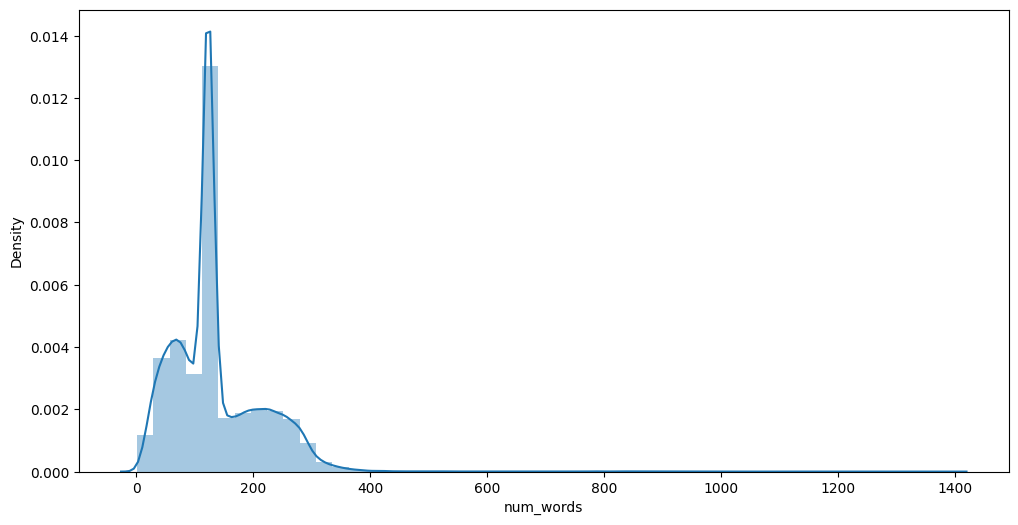

In [10]:
# word length of short_description column
plt.figure(figsize=(12,6))
df['num_words'] = df['short_description'].apply(len)
sns.distplot(df.num_words)

In [11]:
df['num_words'].describe()

count    45749.000000
mean       134.504842
std         77.777536
min          1.000000
25%         84.000000
50%        122.000000
75%        168.000000
max       1392.000000
Name: num_words, dtype: float64

### Text Pre-processing 

In [12]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

def preprocess(text):
    content=re.sub('[^a-zA-Z]', ' ',text)
    content=content.lower()
    content=content.split()
    lemmatizer=WordNetLemmatizer()
    all_stopwords=stopwords.words('english')
    all_stopwords.remove('not')
    
    content=[lemmatizer.lemmatize(word) for word in content if not word in set(all_stopwords)]
    return ' '.join(content)

[nltk_data] Error loading stopwords: <urlopen error [WinError 10054]
[nltk_data]     An existing connection was forcibly closed by the
[nltk_data]     remote host>


In [13]:
df['headline']=df['headline'].apply(lambda x: preprocess(x))
df['short_description']=df['short_description'].apply(lambda x:preprocess(x))

In [14]:
# merge headline and short_description as content
df['content']=df['headline'] + " " + df['short_description']
df.head()

,category,headline,short_description,num_words,content
0,5,u shib sib win world winter olympics debut,brother sister alex maia shibutani took second...,85,u shib sib win world winter olympics debut bro...
1,2,automatic jam jelly maker ball seems like chea...,seem completely ground breaking u yet especial...,85,automatic jam jelly maker ball seems like chea...
2,2,amazing crock pot recipe believe came slow coo...,think crock pot temperature regulated treasure...,66,amazing crock pot recipe believe came slow coo...
3,5,stephen curry started super bowl literal bang,keeppounding,13,stephen curry started super bowl literal bang ...
4,1,power blood chatting buffy sainte marie plus f...,buffy new new album power blood start remake c...,210,power blood chatting buffy sainte marie plus f...


In [15]:
df=df[:10000]

### Splitting the preprocessed dataset into training, validation and test sets

In [16]:
from sklearn.model_selection import train_test_split

X = list(df["content"])
y = list(df["category"])

X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.2,stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.7)

In [17]:
# maximum length of the Description in dataset
max = 0
for i in X:
    if len(i)>max:
        max = len(i)
    
print(max)

879


### Pre-Trained Model

**BERT**

In [18]:
import torch 
from transformers import DistilBertTokenizerFast, TFDistilBertModel

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
model = TFDistilBertModel.from_pretrained(model_name)

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertModel: ['classifier', 'pre_classifier', 'dropout_19']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


### Text Tokenization

In [19]:
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=8, return_tensors = "tf")
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=8, return_tensors = "tf")
X_test_tokenized = tokenizer(X_test, padding="max_length", truncation=True, max_length=8, return_tensors = "tf")

In [20]:
len(X_train_tokenized['input_ids'][1]),len(X_val_tokenized['input_ids'][1]),len(X_test_tokenized['input_ids'][1])

(8, 8, 8)

In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal 
from tensorflow.keras.losses import CategoricalCrossentropy 
from tensorflow.keras.metrics import CategoricalAccuracy 
from tensorflow.keras.utils import to_categorical

### Fine-tuning the pretrained Distilbert 

In [22]:
max_len = 8
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len, ), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids, attention_mask = input_mask)[0]

embeddings = model(input_ids, attention_mask= input_mask)[0] #(0 is the last hidden states, 1 means pooler_output) 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation = 'relu')(out)

y = Dense(10, activation = 'softmax')(out)

model = tf.keras.Model(inputs = [input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

## Model Architecture

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 8)]          0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 8)]          0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 8, 768),                                                     
                                 hidden_states=None                                           

In [24]:
optimizer = Adam(learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)

# Set loss and metrics
loss = CategoricalCrossentropy(from_logits=True)
metric = CategoricalAccuracy('balanced_accuracy')

# Compile the model
model.compile(optimizer = optimizer, loss = loss, metrics = metric)

In [25]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [26]:
train_history = model.fit(
    x = {'input_ids' :X_train_tokenized['input_ids'], 'attention_mask' :X_train_tokenized['attention_mask']},
    y = to_categorical(y_train),
    validation_data = ({'input_ids' :X_val_tokenized['input_ids'], 'attention_mask' :X_val_tokenized['attention_mask']}, to_categorical(y_val)),
    epochs=5)

Epoch 1/5
250/250 [==============================] - 138s 549ms/step - loss: 1.4249 - balanced_accuracy: 0.5410 - val_loss: 1.1163 - val_balanced_accuracy: 0.6650
Epoch 2/5
250/250 [==============================] - 142s 570ms/step - loss: 0.8850 - balanced_accuracy: 0.7305 - val_loss: 1.0718 - val_balanced_accuracy: 0.6900
Epoch 3/5
250/250 [==============================] - 147s 590ms/step - loss: 0.7220 - balanced_accuracy: 0.7809 - val_loss: 1.0863 - val_balanced_accuracy: 0.7000
Epoch 4/5
250/250 [==============================] - 133s 533ms/step - loss: 0.6216 - balanced_accuracy: 0.8190 - val_loss: 1.1012 - val_balanced_accuracy: 0.6933
Epoch 5/5
250/250 [==============================] - 123s 490ms/step - loss: 0.5423 - balanced_accuracy: 0.8384 - val_loss: 1.1197 - val_balanced_accuracy: 0.7017


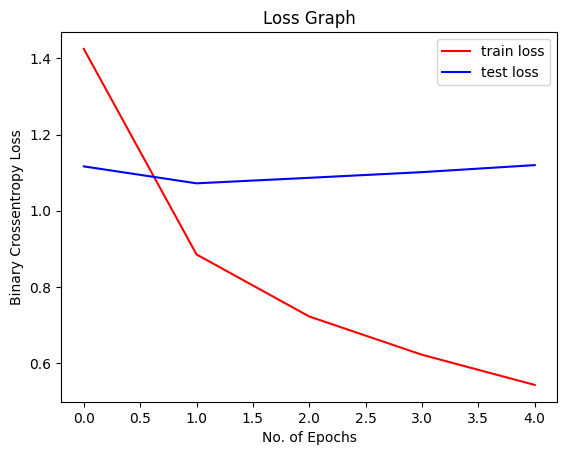

In [27]:
plt.plot(train_history.history['loss'],'r',label='train loss')
plt.plot(train_history.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.title('Loss Graph')
plt.legend()

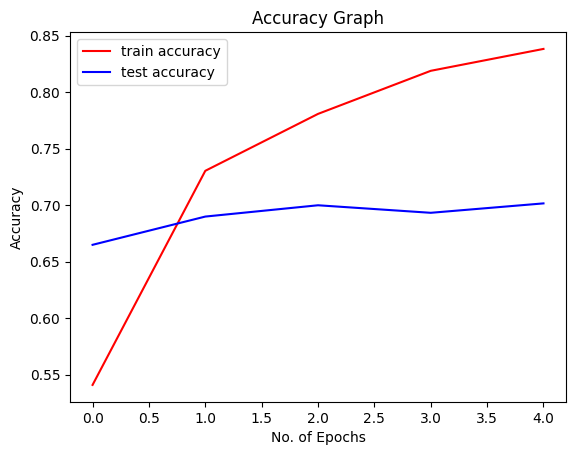

In [28]:
plt.plot(train_history.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(train_history.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()

In [29]:
pred_raw = model.predict({'input_ids' :X_test_tokenized['input_ids'], 'attention_mask' :X_test_tokenized['attention_mask']})
y_pred = np.argmax(pred_raw, axis=1)

44/44 [==============================] - 6s 128ms/step


In [30]:
from sklearn.metrics import classification_report
cr = classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.63      0.64      0.64       129
           1       0.66      0.66      0.66       150
           2       0.77      0.86      0.81       142
           3       0.71      0.77      0.74       142
           4       0.71      0.59      0.65       147
           5       0.75      0.78      0.77       130
           6       0.73      0.75      0.74       130
           7       0.75      0.70      0.73       138
           8       0.65      0.70      0.68       140
           9       0.84      0.76      0.80       152

    accuracy                           0.72      1400
   macro avg       0.72      0.72      0.72      1400
weighted avg       0.72      0.72      0.72      1400



### Testing with few examples

In [31]:
dict_val={'BUSINESS':0,
'ENTERTAINMENT':1,
'FOOD & DRINK':2,
'PARENTING':3,
'POLITICS':4,
'SPORTS':5,
'STYLE & BEAUTY':6,
'TRAVEL':7,
'WELLNESS':8,
'WORLD NEWS':9 }

In [32]:
# Test case - 1

texts = str("selling rio silver medal help year old cancer true champion piotr malachowski")
test_tokenized = tokenizer(text=texts, padding="max_length", truncation=True, max_length=8, return_tensors = "tf")
validate = model.predict({'input_ids' :test_tokenized['input_ids'], 'attention_mask' :test_tokenized['attention_mask']})*100 
for key,value in zip(dict_val.keys(), validate[0]):
    print(key,value)

1/1 [==============================] - 0s 175ms/step
BUSINESS 20.477053
ENTERTAINMENT 4.431656
FOOD & DRINK 1.906552
PARENTING 1.4243315
POLITICS 1.9266357
SPORTS 7.399468
STYLE & BEAUTY 0.8153137
TRAVEL 19.47909
WELLNESS 1.9282993
WORLD NEWS 40.2116


In [33]:
# Test case - 2

texts = str("obama confronts corporate tax reform past lesson suggest lobbyist fight loophole john buckley democrat chief counsel way mean committee time said thomas decided")
test_tokenized = tokenizer(text=texts, padding="max_length", truncation=True, max_length=8, return_tensors = "tf")
validate = model.predict({'input_ids' :test_tokenized['input_ids'], 'attention_mask' :test_tokenized['attention_mask']})*100 
for key,value in zip(dict_val.keys(), validate[0]):
    print(key,value)

1/1 [==============================] - 0s 150ms/step
BUSINESS 18.950792
ENTERTAINMENT 0.46819574
FOOD & DRINK 0.25290152
PARENTING 2.3015108
POLITICS 75.251366
SPORTS 1.2147622
STYLE & BEAUTY 0.0871539
TRAVEL 0.050182186
WELLNESS 0.4393856
WORLD NEWS 0.9837558


In [34]:
# Test case - 3

texts = str("alanis morissette ditch tough image softer look photo look never go style")
test_tokenized = tokenizer(text=texts, padding="max_length", truncation=True, max_length=8, return_tensors = "tf")
validate = model.predict({'input_ids' :test_tokenized['input_ids'], 'attention_mask' :test_tokenized['attention_mask']})*100 
for key,value in zip(dict_val.keys(), validate[0]):
    print(key,value)

1/1 [==============================] - 0s 156ms/step
BUSINESS 0.2898894
ENTERTAINMENT 2.7501802
FOOD & DRINK 0.32724157
PARENTING 0.12363454
POLITICS 0.059796054
SPORTS 0.05484691
STYLE & BEAUTY 95.56508
TRAVEL 0.16658288
WELLNESS 0.44026262
WORLD NEWS 0.22248751
